In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline
import seaborn as sns
import glob

sns.set()

In [2]:

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Get a list of all CSV files in the directory
csv_files = glob.glob('*.csv')  # Assuming all CSV files are in the same directory

# Define the columns to select
columns_to_select = [
    'products-link-href',
    'products-name',
    'products-price',
    'products-rating'
]

for csv_file in csv_files:
    try:
        # Read each CSV file and select the desired columns
        df = pd.read_csv(csv_file, usecols=columns_to_select)
        
        # Append the selected columns to the merged DataFrame
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    except ValueError as e:
        print(f"Skipping {csv_file} due to the following error: {e}")

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)


In [3]:

def process_product_price(df):
    # Create a boolean mask to identify rows where 'product_price' cannot be converted to float
    mask = pd.to_numeric(df['products-price'], errors='coerce').isna()
    mask_1 = pd.to_numeric(df['products-rating'], errors='coerce').isna()

    # Drop rows where 'product_price' cannot be converted to float
    df = df[~mask]
    df = df[~mask_1]

    # Convert the 'product_price' column to float
    df['products-price'] = df['products-price'].astype(float)
    df['products-rating'] = df['products-rating'].astype(float)

    return df


# Process the DataFrame using the function
df = process_product_price(merged_df)



<ipython-input-3-0d162646de21>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~mask_1]


In [4]:
df['products-link-href'] = df['products-link-href'].astype(str)
df['products-name'] = df['products-name'].astype(str)
df['products-price'] = df['products-price'].astype('float32')
df['products-rating'] = df['products-rating'].astype('float32')

In [5]:
df[df.isnull().any(axis=1)].count()

products-link-href    0
products-name         0
products-price        0
products-rating       0
dtype: int64

<AxesSubplot:>

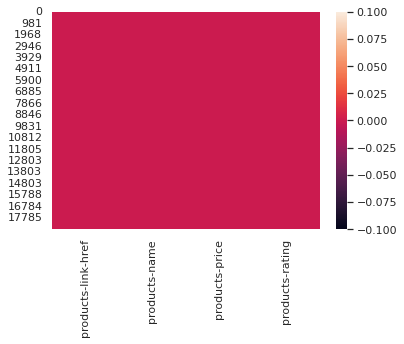

In [6]:
sns.heatmap(df.isnull())

In [7]:
df.describe()

,products-price,products-rating
count,1.856100e+04,18561.000000
mean,4.249909e+03,1.664706
std,2.659778e+04,2.499047
min,0.000000e+00,0.000000
25%,2.000000e+02,0.000000
50%,4.800000e+02,0.000000
75%,1.450000e+03,4.200000
max,1.800000e+06,180.000000


In [8]:
product_name = input()

Samsung Galaxy A51 6GB 128GB


In [9]:
new_row_data = {'products-link-href': 'Null', 'products-name': product_name, 'products-price': 0.0, 'products-rating': 0.0}


new_row_df = pd.DataFrame([new_row_data])

# Concatenate the new DataFrame with the original DataFrame, and reset the index
df = pd.concat([df, new_row_df]).reset_index(drop=True)

In [10]:
df.tail(5)

,products-link-href,products-name,products-price,products-rating
18557,https://sindabad.com/hp-201a-original-laserjet...,"HP 201A Original LaserJet Toner Cartridge, Mag...",7250.0,0.0
18558,https://sindabad.com/osaka-pvc-tape-black.html,"Osaka PVC Tape, Black",23.0,0.0
18559,https://sindabad.com/afk-fingertip-pulse-oxime...,AFK Fingertip Pulse Oximeter,1399.0,0.0
18560,https://sindabad.com/double-needle-bobbin-alum...,"Henxeng Double Needle Bobbin, Aluminium",5.0,0.0
18561,Null,Samsung Galaxy A51 6GB 128GB,0.0,0.0


In [11]:
name = df['products-name'].str.lower()
name.head(10)

0             emami 7 oils in one pumpkin plus - 100ml
1    kodomo professional children milk teeth toothb...
2      gucci - memoire eau de parfum for women - 100mi
3    dove - go fresh pomegranate roll-on anti-persp...
4      kodomo grape flavor children's toothpaste - 40g
5          johnson's baby cotton touch wipes 56 pieces
6    aveeno skin relief dry skin body wash - chamom...
7                         everyday lipstick - combo 01
8    ogx - renewing argan oil of morocco extra pnet...
9       emami - kesh king plus herbal hair oil - 100ml
Name: products-name, dtype: object

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

import pandas as pd

# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
x = count_vectorizer.fit_transform(df['products-name'].values.astype('U'))

x

<18562x9458 sparse matrix of type '<class 'numpy.int64'>'
	with 139006 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
P = cosine_similarity(x, x)

In [14]:
P

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
l1 = len(P)
l1 = l1-1

In [16]:
# Initialize empty lists to store values and indices
selected_values = []
selected_indices = []

# Step 1: Filter values based on a condition
for i in range(len(P)):
    if 0.3 <= P[i][l1] <= 0.9999999:
        selected_values.append(P[i][l1])
        selected_indices.append(i)

# Step 2: Sort selected values in descending order along with their indices
sorted_values_with_indices = sorted(zip(selected_values, selected_indices), reverse=True)

# Step 3: Extract sorted indices
sorted_indices = [index for _, index in sorted_values_with_indices]

# Step 4: Create a list of product ratings based on sorted indices
rating_list = [df.loc[i]['products-rating'] for i in sorted_indices]

# Step 5: Sort product ratings along with their indices
sorted_ratings_with_indices = sorted(zip(rating_list, sorted_indices), reverse=True)

# Step 6: Extract final sorted indices
sorted_final_indices = [index for _, index in sorted_ratings_with_indices]

# Step 7: Print the top 5 rows from the DataFrame based on sorted indices
for i, index in enumerate(sorted_final_indices):
    print(f"Top product {i + 1}:")
    print(df.loc[index])
    if i >= 4:  # Print the top 5 products
        break


Top product 1:
products-link-href    https://www.pickaboo.com/samsung-galaxy-note10...
products-name                               Samsung Galaxy Note 10 Lite
products-price                                                  44999.0
products-rating                                                     4.7
Name: 18377, dtype: object
Top product 2:
products-link-href    https://www.pickaboo.com/samsung-galaxy-m01-co...
products-name                          Samsung Galaxy M01 Core 1GB/16GB
products-price                                                   6299.0
products-rating                                                     4.7
Name: 18309, dtype: object
Top product 3:
products-link-href    https://www.pickaboo.com/samsung-galaxy-note10...
products-name                               Samsung Galaxy Note 10 Lite
products-price                                                  44999.0
products-rating                                                     4.7
Name: 14314, dtype: object
Top produc